# Подключаем нужные библиотеки

In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [2]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [3]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [4]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 178 ms, sys: 421 µs, total: 178 ms
Wall time: 174 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [5]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [6]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

CPU times: user 54.2 ms, sys: 23.4 ms, total: 77.5 ms
Wall time: 76.1 ms


Пример того, как выглядят тесты для полноградиентного случая

In [7]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 141 µs, sys: 0 ns, total: 141 µs
Wall time: 144 µs


In [8]:
num_of_tests = 600

In [9]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

CPU times: user 4.12 s, sys: 0 ns, total: 4.12 s
Wall time: 4.12 s


In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 20.7 s, sys: 0 ns, total: 20.7 s
Wall time: 20.7 s


Пример тестов для случая стох. градиентов

In [11]:
batch_size = 1
num_of_tests = 10000

In [12]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 7.13 s, sys: 19.3 ms, total: 7.15 s
Wall time: 7.15 s


In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 509 ms, sys: 23 µs, total: 509 ms
Wall time: 506 ms


Зафиксируйте здесь результаты своих экспериментов:

In [4]:
batch_lst = [1, 10, 100, 'full']
num_of_tests = 100

def experiment(dataset):
    A, y, m, n, sparsity_A = prepare_data(dataset)
    L, average_L, worst_L = compute_L(dataset, A)
    
    denseA = A.toarray()
    batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)
    
    # sparse matrix 
    start_time = time.time()
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [A, y, 0, True])
    delta_sparse_gd = time.time() - start_time
    
    # dense matrix
    start_time = time.time()
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
            logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
    delta_dense_gd = time.time() - start_time
    
    # stochastic gd sparse
    dense_time = []
    sparse_time = []
    full_time = []
    for batch in batch_lst:
        start = time.time()
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
        delta_sparse_sgd = time.time() - start
        sparse_time.append(delta_sparse_sgd)
        
        start = time.time()
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
        delta_dense_sgd = time.time() - start
        dense_time.append(delta_dense_sgd)
        
        if batch == 'full':
            start = time.time()
            for j in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    logreg_grad(x, [A, y, 0, True])
            delta_sparse_sgd = time.time() - start
            sparse_time.append(delta_sparse_sgd)

            start = time.time()
            for j in range(5):
                x = norm_d.rvs(size=n)
                for i in range(num_of_tests):
                    logreg_grad(x, [denseA, y, 0, False])
            delta_dense_sgd = time.time() - start
            dense_time.append(delta_dense_sgd)

    
    result = {'Dataset': dataset, 
                "Число функций в сумме": m, 
                "размерность задачи": n, 
                "Константа гладкости всей функции": L,
                'Средняя константа гладкости'     : average_L, 
                "Худшая константа гладкости ": worst_L, 
                "Доля ненулевых элементов": sparsity_A, 
              'GD sparse A': delta_sparse_gd, 
              'GD dense A': delta_dense_gd, 
              'SGD sparse A, batch 1': sparse_time[0],
              'SGD dense A, batch 1':dense_time[0],
              'SGD sparse A, batch 10':sparse_time[1],
              'SGD dense A, batch 10':dense_time[1],
              'SGD sparse A, batch 100':sparse_time[2],
              'SGD dense A, batch 100':dense_time[2],
             'SGD sparse A, batch full':sparse_time[3],
              'SGD dense A, batch full':dense_time[3],
             }
    return result

In [31]:
datasets = ['a9a', 'gisette_scale', 'australian', 'heart', 'diabetes'] # gisette
result = []
for dataset in datasets:
    result.append(experiment(dataset))

In [32]:
import pandas as pd
pd.DataFrame(result)

,Dataset,Число функций в сумме,размерность задачи,Константа гладкости всей функции,Средняя константа гладкости,Худшая константа гладкости,Доля ненулевых элементов,GD sparse A,GD dense A,"SGD sparse A, batch 1","SGD dense A, batch 1","SGD sparse A, batch 10","SGD dense A, batch 10","SGD sparse A, batch 100","SGD dense A, batch 100","SGD sparse A, batch full","SGD dense A, batch full"
0,a9a,32561,123,1.571920e+00,3.467277e+00,3.500000e+00,0.112757,0.578611,0.072741,0.070467,0.004960,0.071175,0.004938,0.070750,0.004941,0.070896,0.004975
1,gisette_scale,6000,5000,8.428680e+02,1.163345e+03,1.201509e+03,0.991000,74.652680,0.080099,0.079761,0.017563,0.080048,0.012878,0.079696,0.012879,0.079766,0.012914
2,australian,690,14,7.036285e+06,7.051932e+06,2.500101e+09,0.799586,0.050300,0.070185,0.069861,0.004883,0.069866,0.004825,0.069785,0.004838,0.071306,0.004830
3,heart,270,13,2.671068e+04,2.714773e+04,9.036964e+04,0.750997,0.042227,0.070094,0.070075,0.004858,0.070091,0.004844,0.070218,0.004816,0.070250,0.004878
4,diabetes,768,8,8.606923e+03,1.086225e+04,1.899885e+05,0.875814,0.046673,0.070178,0.071543,0.004805,0.073482,0.004852,0.073408,0.004803,0.070785,0.004785


Из полученного результата можно заметить, что практически во всех случаях dense матрица считается в несколько раз, а где-то даже на порядок быстрее, чем sparse. 

Можно заметить, что , если матрица не сильно разрежена, то полный градиент быстрее считается со sparse матрицей. Если матрица сильно разрежена или не разрежена, то sparse матрица считается дольше в случае полного градиента. 

Также для стохастического градиентного спуска при увеличении размера батча разница между sparse и dense уменьшается, но все равно остается ощутимой. 

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [13]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.maximum(np.abs(x) - lamb, 0) * np.sign(x) 

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [14]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [15]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 155 ms, sys: 19.4 ms, total: 174 ms
Wall time: 170 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [8]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 4.78 ms, sys: 4.08 ms, total: 8.86 ms
Wall time: 7.64 ms


array([ 4501, 27964,  4430, ..., 10850, 12816, 27700])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [18]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 43.8 s, sys: 1.09 s, total: 44.9 s
Wall time: 43.8 s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [9]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [10]:
%%time
import algorithms
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 797 ms, sys: 28 ms, total: 825 ms
Wall time: 824 ms


Запустите функцию, тестирующую корректность работы

In [11]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [5]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [21]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [22]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [13]:
# ваш код здесь
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 50 # как в пдф
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [ ]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

In [14]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.3578568111141975
Процент ненулевых координат в найденном решении:  0.2845528455284553
CPU times: user 12.6 s, sys: 44.8 ms, total: 12.7 s
Wall time: 12.7 s


In [15]:
ls = [L / 10000, L / 1000, L / 100, 0]
result = []
for i, l1 in enumerate(ls):
    param = [A, y, l2, True, l1]
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
         l1=l1, S=S, M=M, max_t=np.inf,
         batch_size=batch_size, indices=None, save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])
    print()
    result.append(res)
    print('L1 =', ls[i])
    print("Найденное значение: ", res['func_vals'][-1])
    print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)


L1 = 0.0001571919699222661
Найденное значение:  0.33029607824078105
Процент ненулевых координат в найденном решении:  0.5365853658536586

L1 = 0.001571919699222661
Найденное значение:  0.3578568111141976
Процент ненулевых координат в найденном решении:  0.2845528455284553

L1 = 0.01571919699222661
Найденное значение:  0.4718535995096705
Процент ненулевых координат в найденном решении:  0.10569105691056911

L1 = 0
Найденное значение:  0.32527807383968743
Процент ненулевых координат в найденном решении:  1.0


Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [45]:
ls_str = [0, 'L / 100', 'L / 1000', 'L / 10000']
for i, l1 in enumerate(ls_str):
    print('The value of l1=', l1)
    print("Найденное значение: ", result[i]['func_vals'][-1])
    print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(result[i]['last_iter'])/n)
    print(result_solver[i])

The value of l1= 0
Найденное значение:  0.3252780736663675
The value of l1= L / 100
Найденное значение:  0.47185359950967054
The value of l1= L / 1000
Найденное значение:  0.35785681111419754
The value of l1= L / 10000
Найденное значение:  0.3302960782425744


In [16]:
%%time
param = [A, y, l2, True, 0]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 566
         Function evaluations: 569
         Gradient evaluations: 569
0.3252780301519581
CPU times: user 8.25 s, sys: 188 ms, total: 8.44 s
Wall time: 1.42 s


In [17]:
%%time
param = [A, y, l2, True, L/1000]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357857
         Iterations: 986
         Function evaluations: 1063
         Gradient evaluations: 1063
0.3578568111142156
CPU times: user 15.7 s, sys: 328 ms, total: 16 s
Wall time: 2.66 s


Для значения l1 = 0 и l1 = L / 1000 (когда процент ненулевых координат в решении находится в промежутке от 10 до 30 %) при S = 50 найденное значение соответствует получаемому с помощью стандартного солвера из scipy с точностью до 7 знака после запятой. 

Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [18]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [19]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 794 ms, sys: 18 µs, total: 794 ms
Wall time: 792 ms


Следующая функция позволяет строить графики

In [6]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [21]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

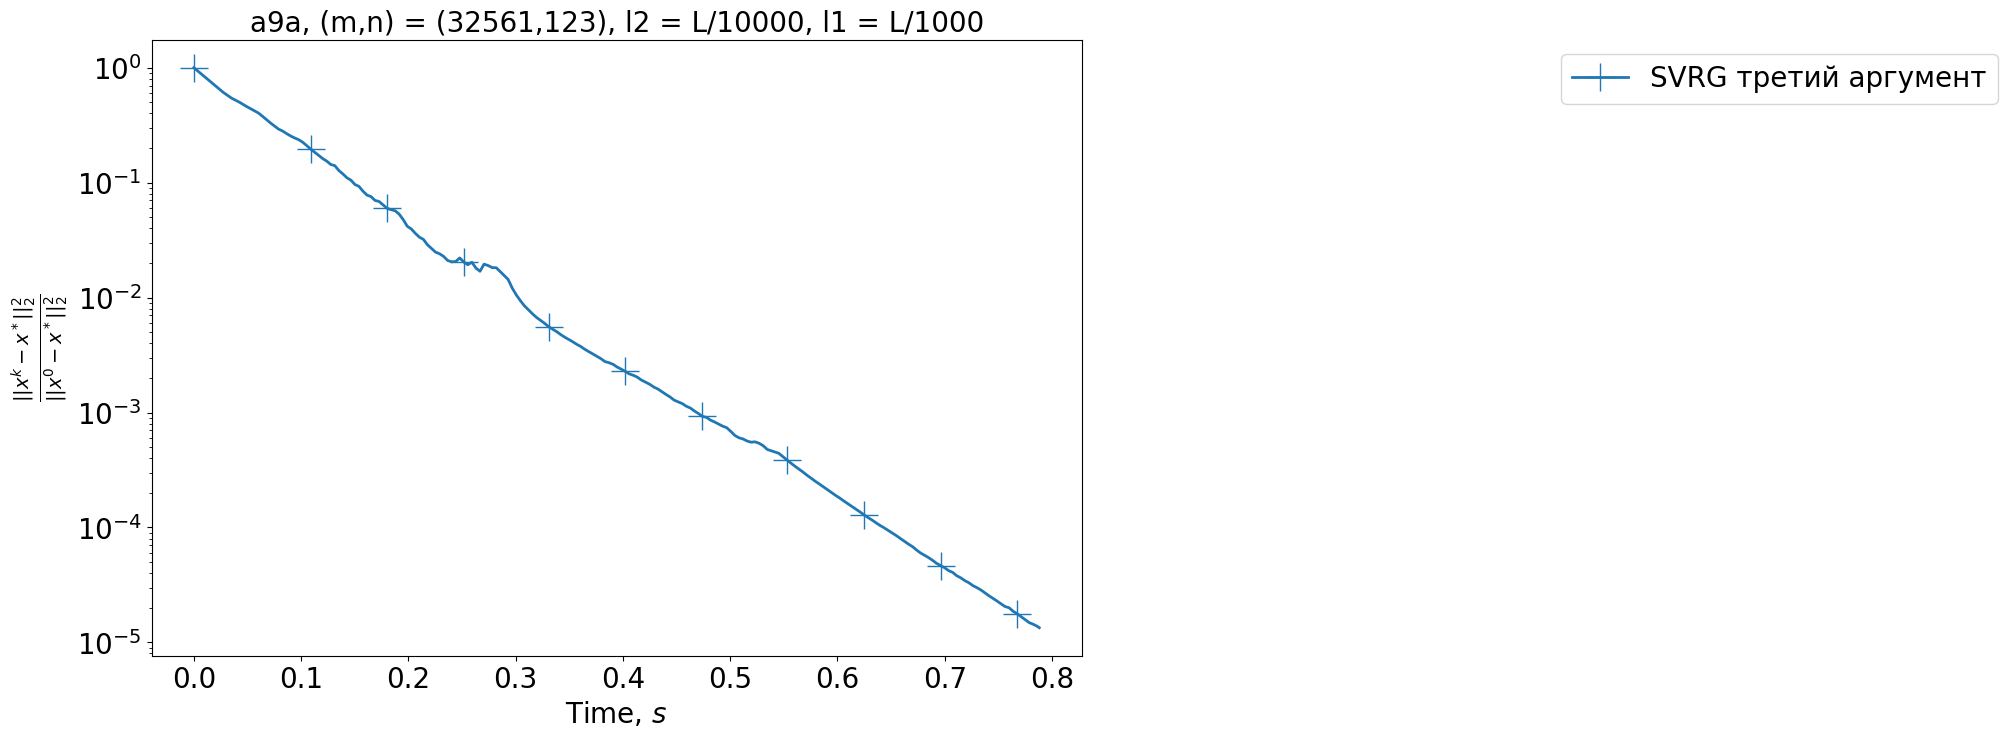

In [22]:
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [34]:
batches = [1, 10, 100]
ls = [L / 10000, L / 1000, L / 100]

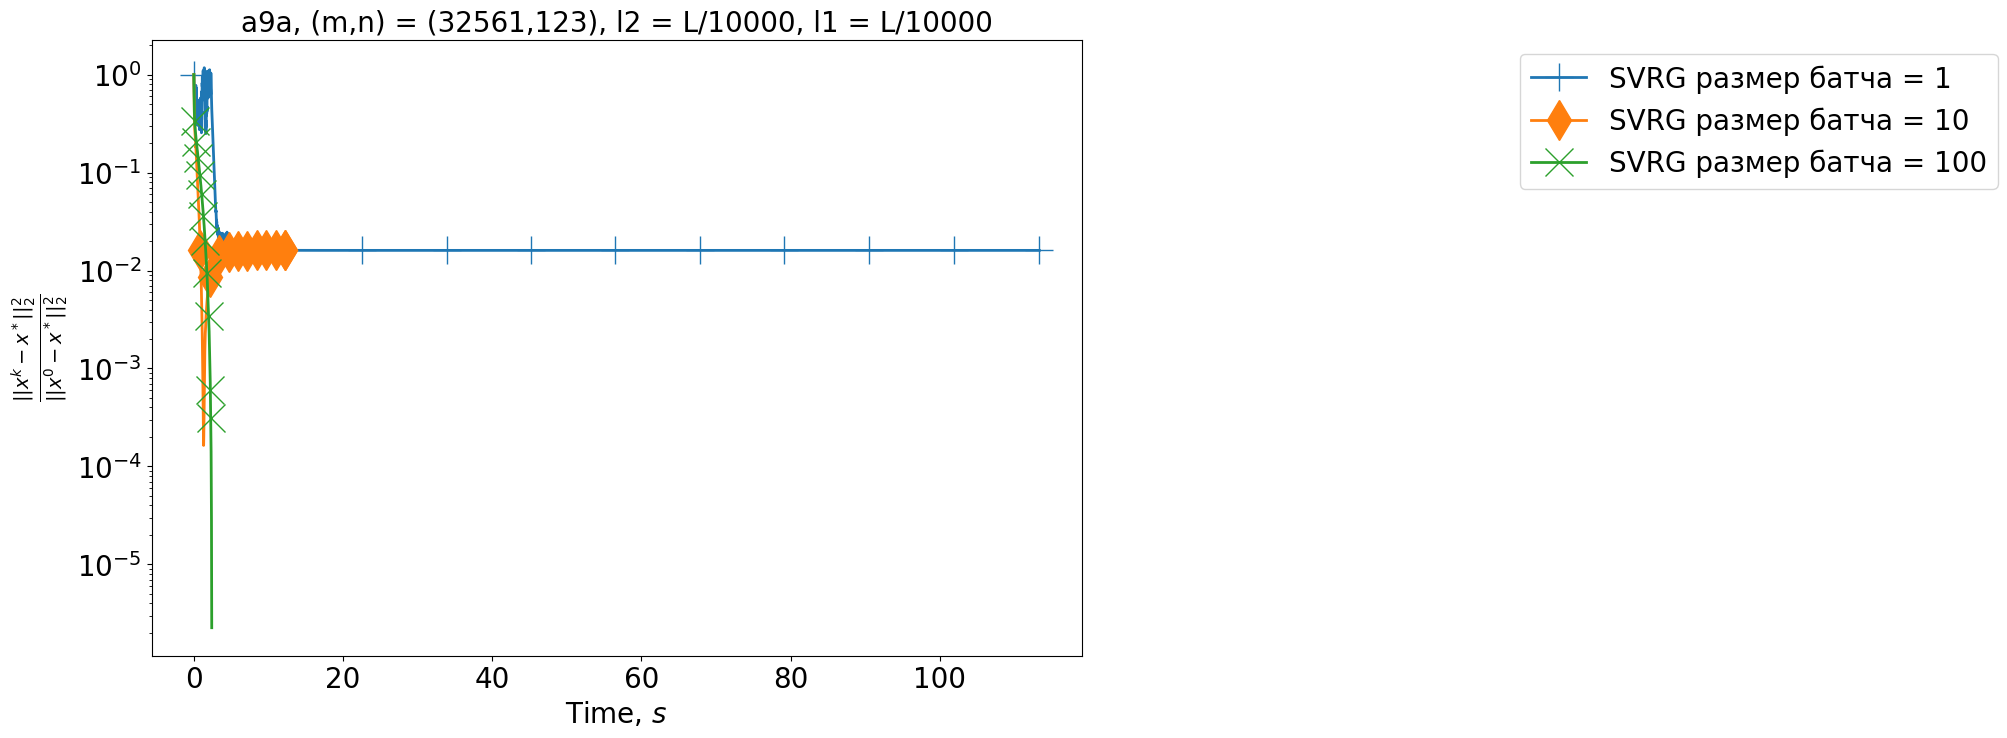

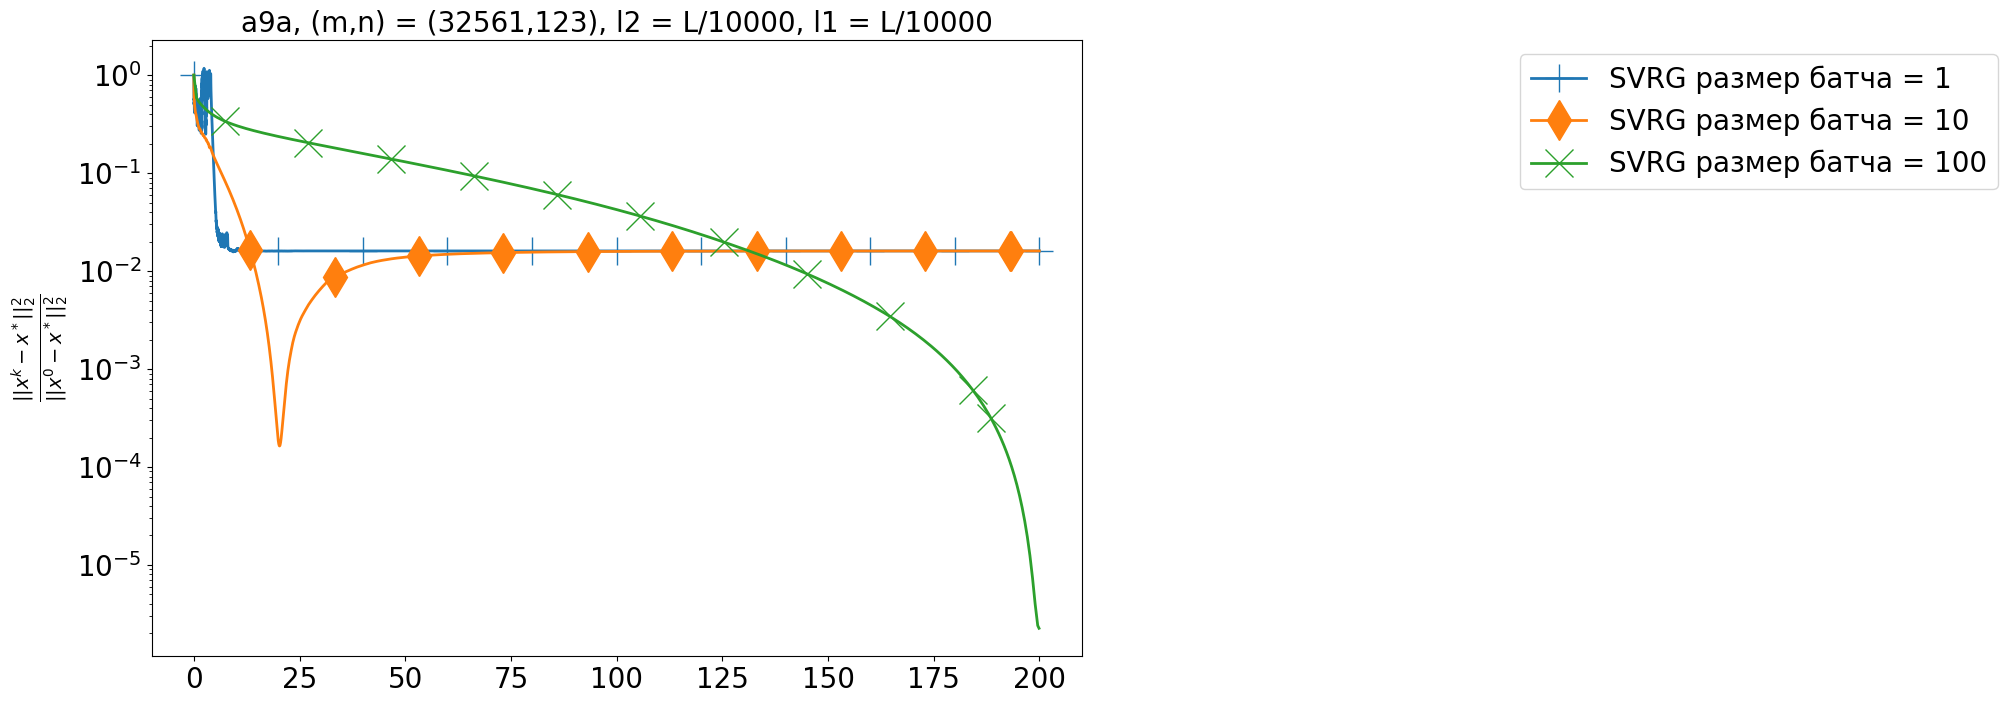

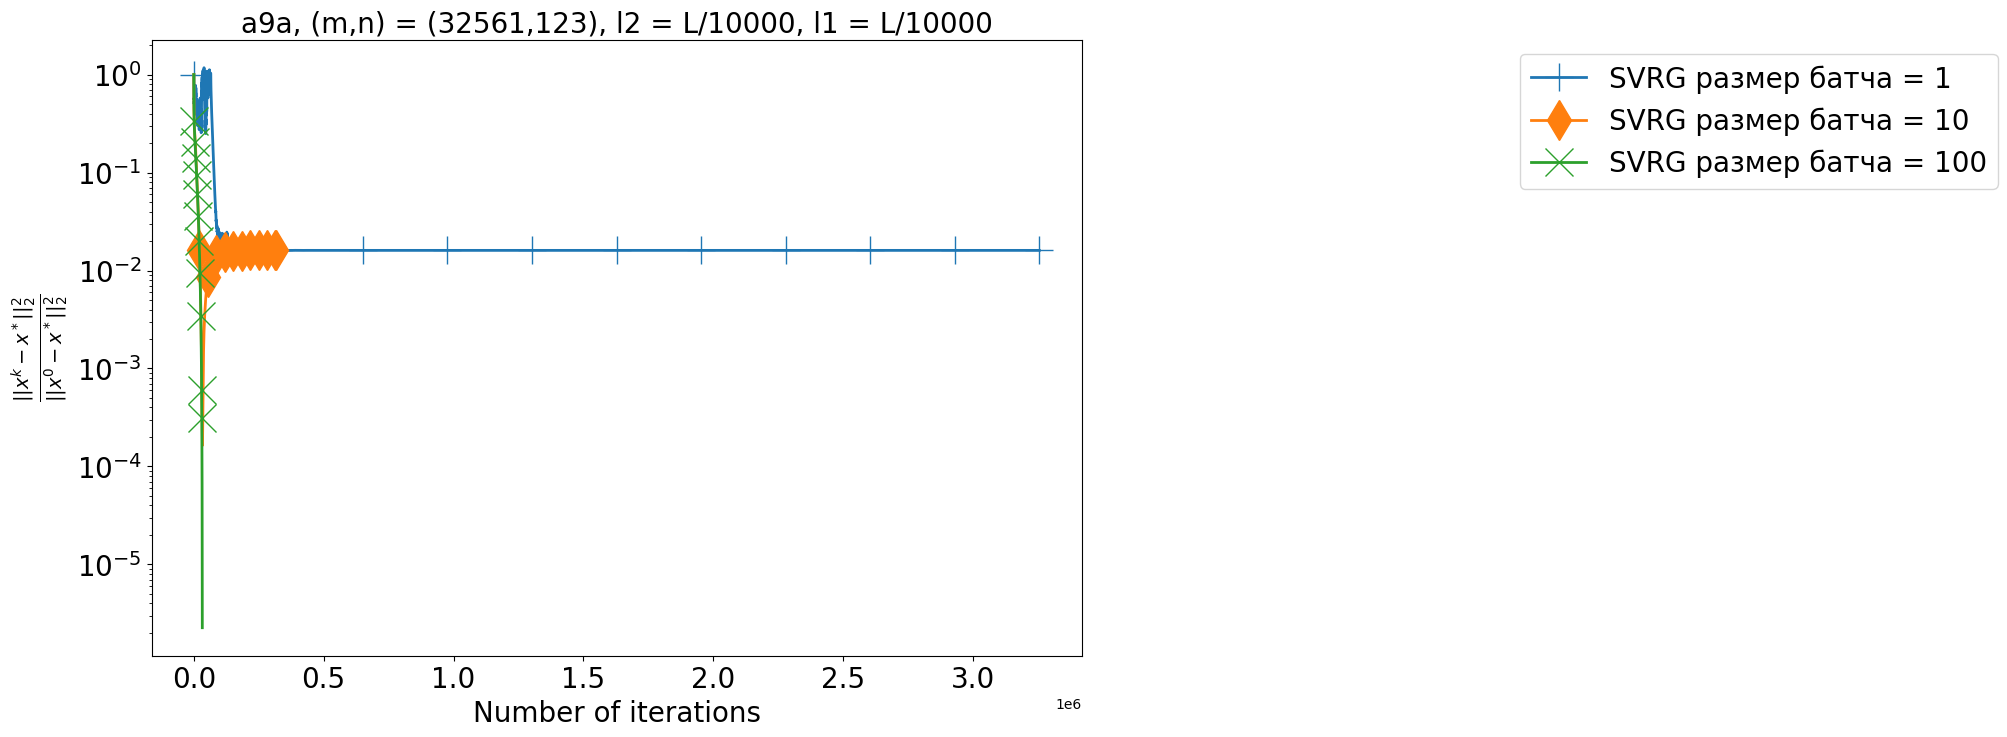

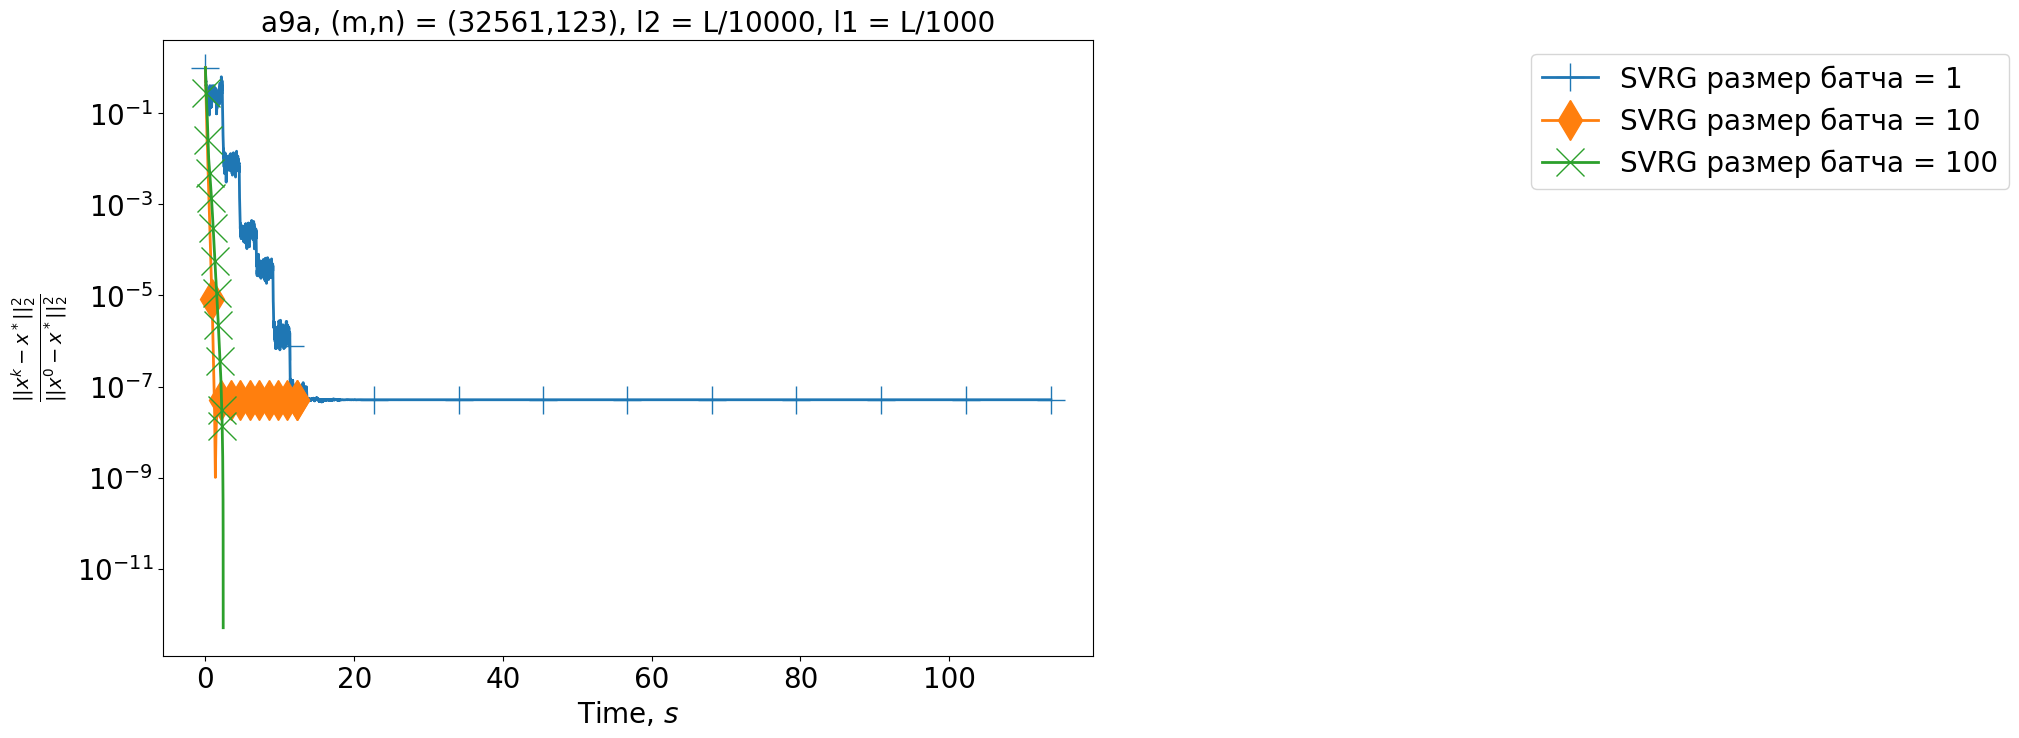

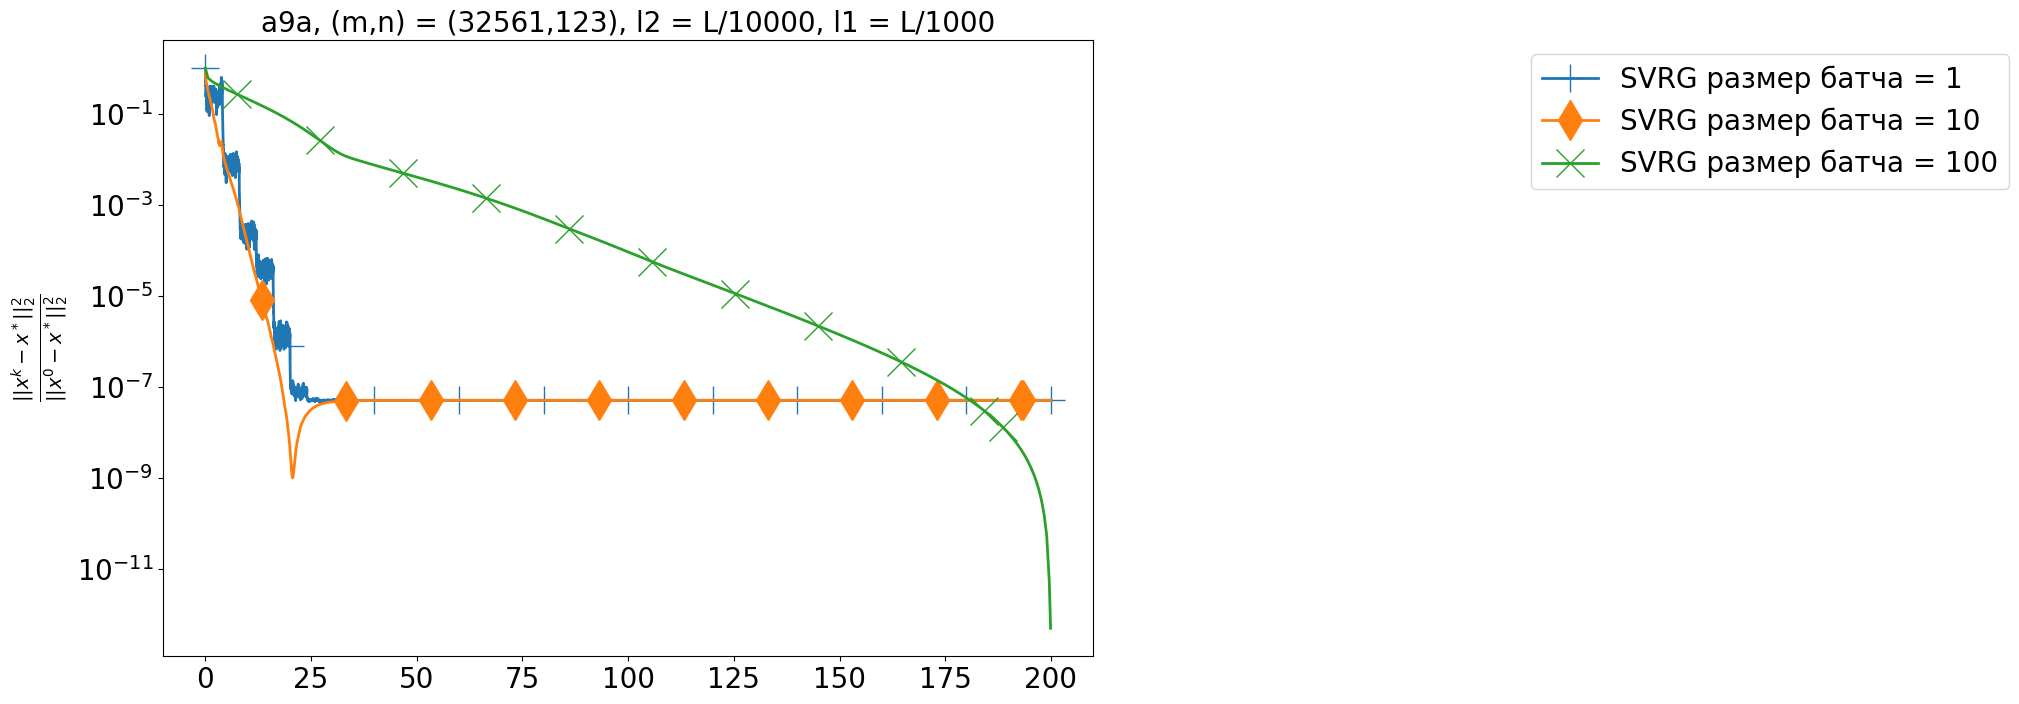

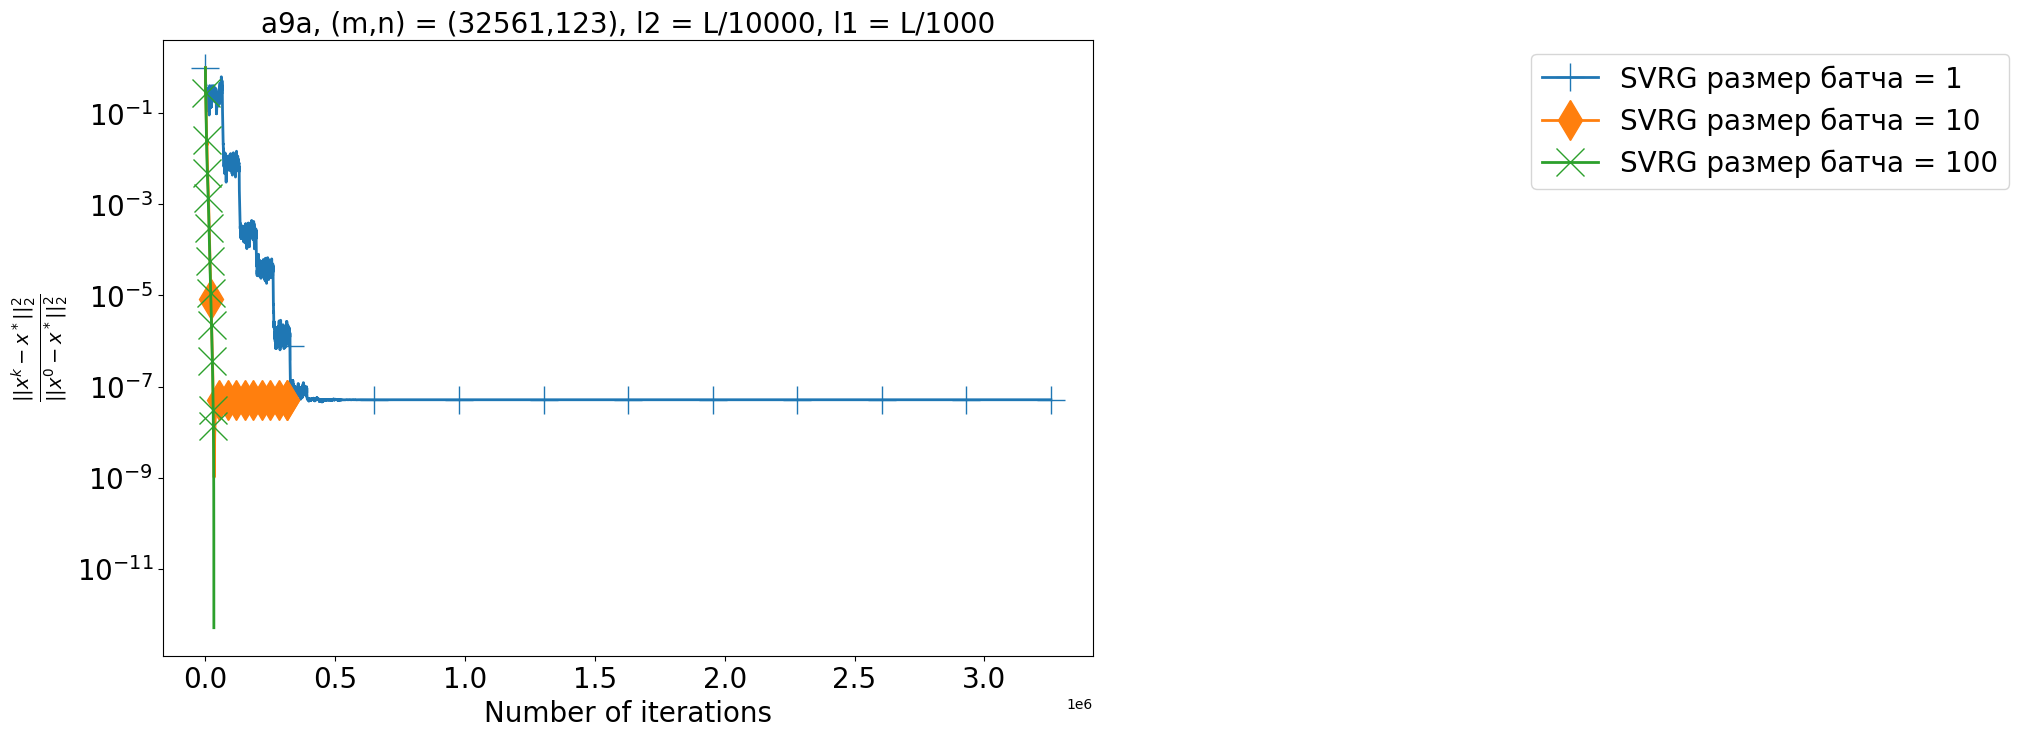

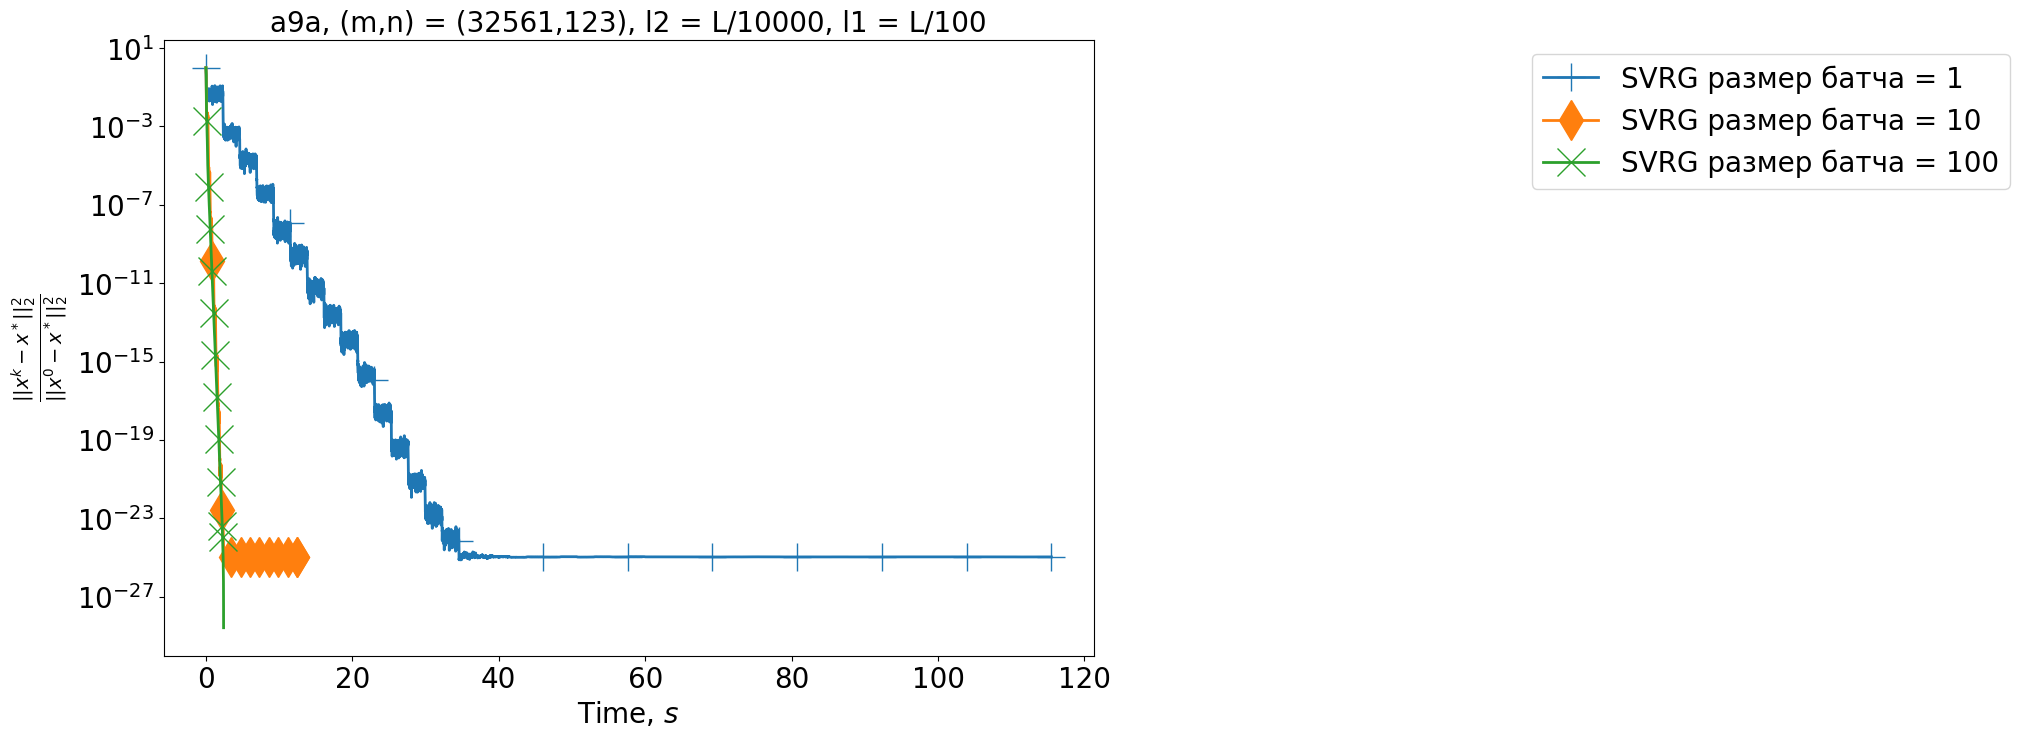

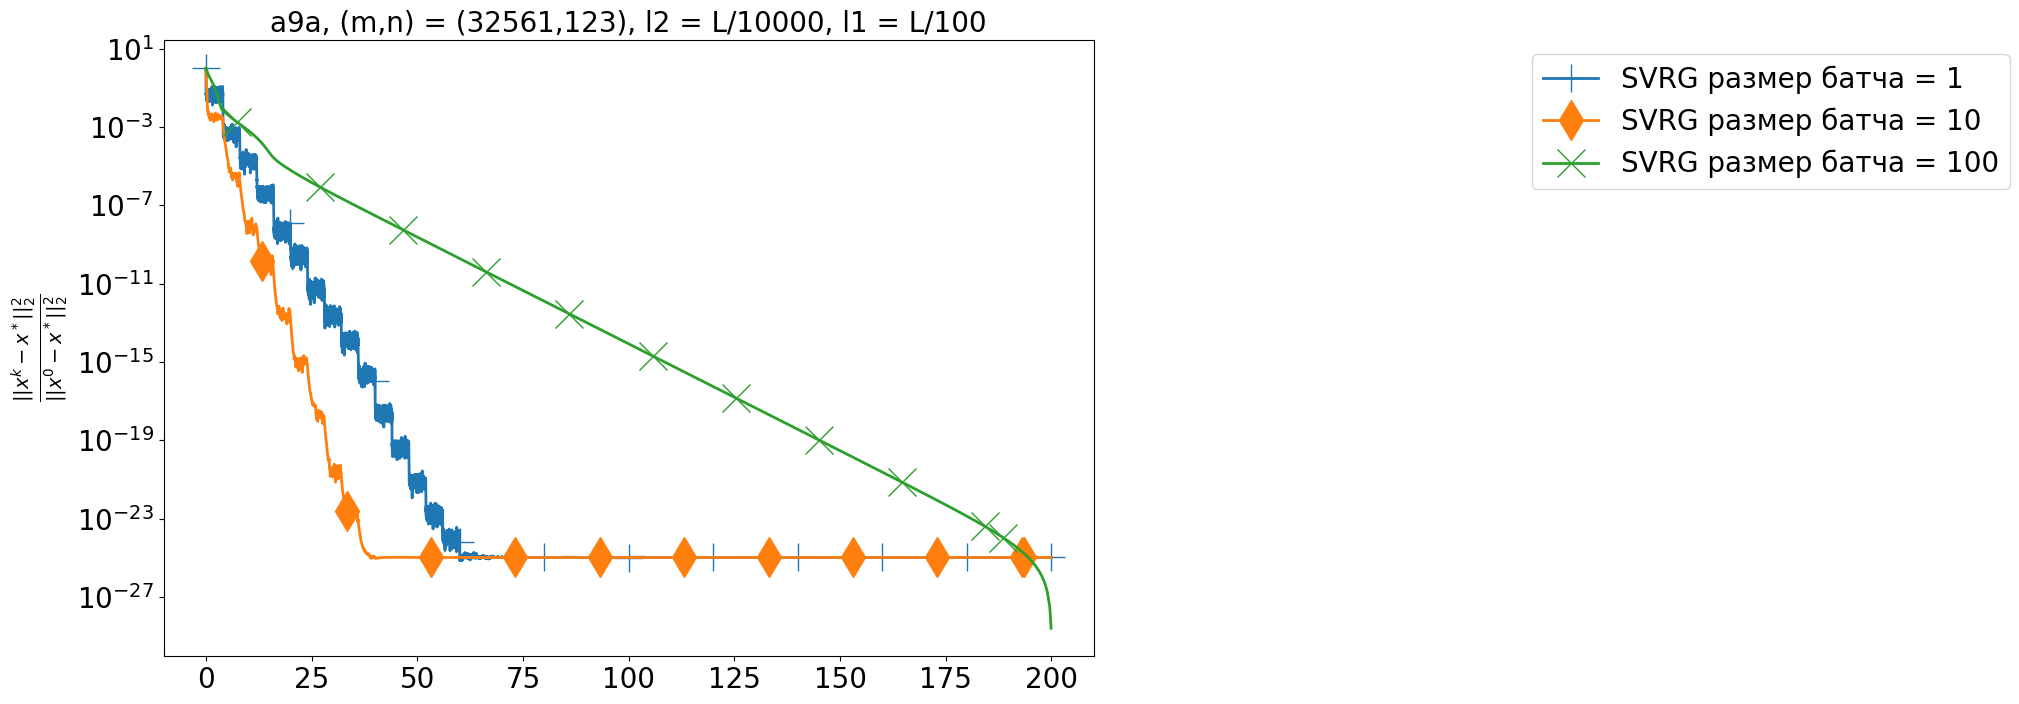

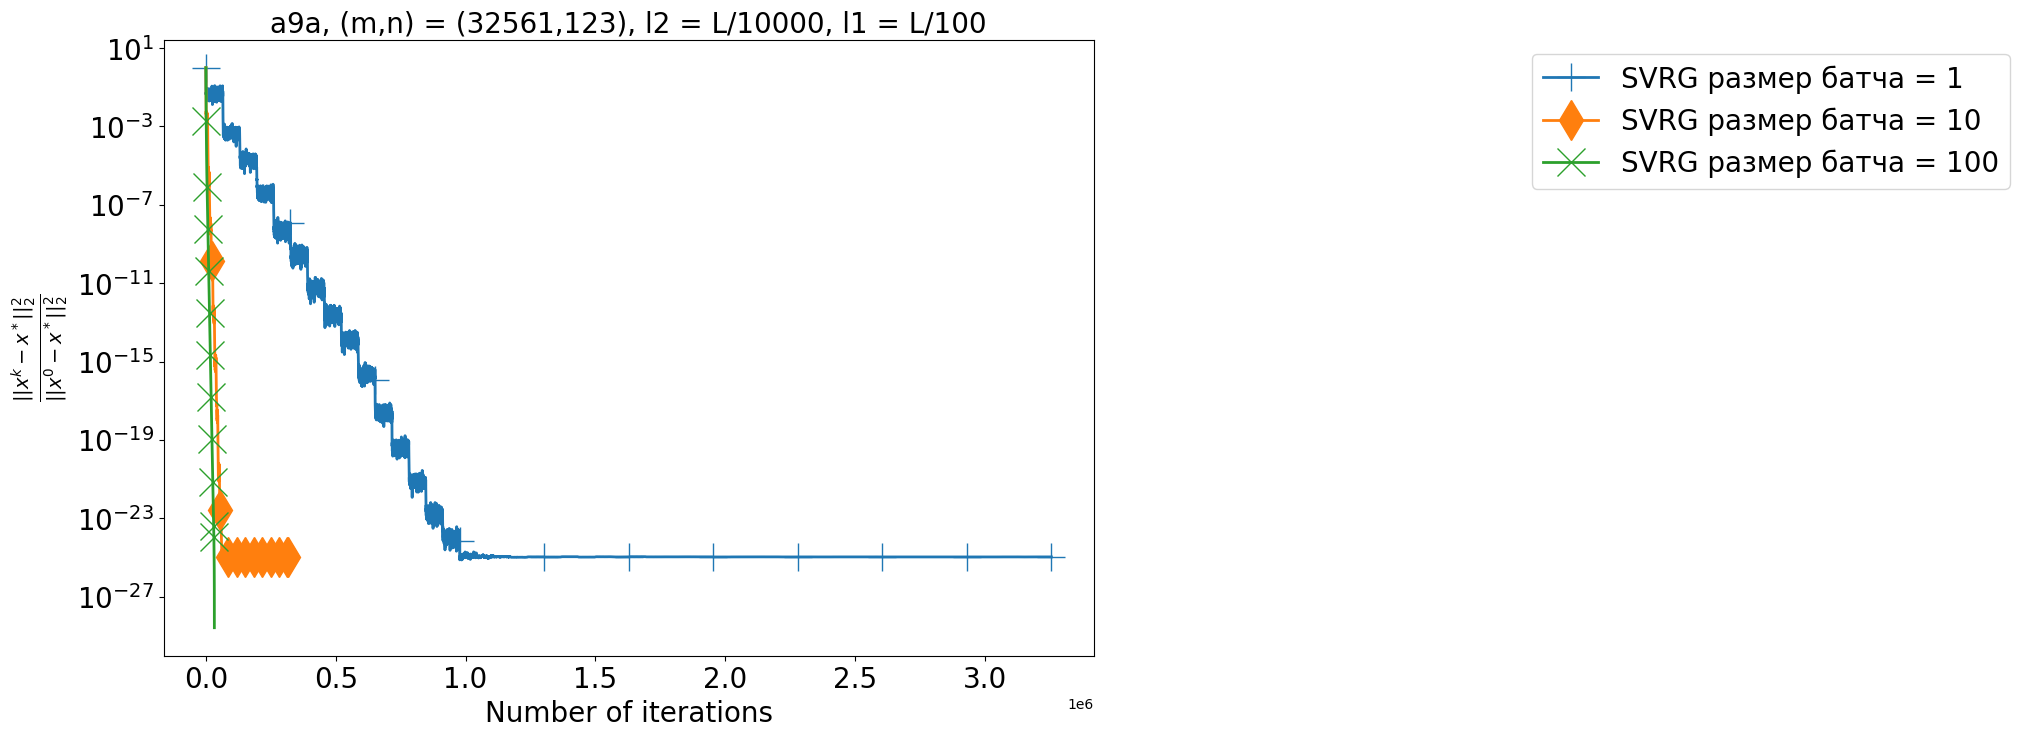

In [65]:
dataset = 'a9a'
filename = dataset + "_x_init_all_ones"
x_init = np.ones(n)
l2 =  L / 10000
S = 50
figsize = (12, 8)
fontsize = 20
x_init = np.ones(n)
sparse_full, sparse_stoch = False, False
gamma = 1.0 / (6 * (L + l2))
save_info_period = 100
mode_x = ['time', 'data_passes', 'iters']

for l1 in ls:
    methods = []
    param = [A, y, l2, True, l1]
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    for batch_size in batches:
        M = int(2 * m / batch_size)
        methods.append(['SVRG', [gamma, l2, l1, S, int(2*m/batch_size), batch_size], f' размер батча = {batch_size}', None])
        res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, M=M, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])
    for mode in mode_x:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
        args_for_plots = [dataset, filename, mode_y, mode, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

    1) Для среднего и большого размеров батча метод сходится наиболее быстро по числу итераций (от 10 до 100). 
    2) По числу эпох метод со средним батчом сходится наиболее быстро. 
    3) Для большого батча метод сходится наиболее быстро по времени. 

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [41]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [42]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 296 ms, sys: 7.97 ms, total: 304 ms
Wall time: 303 ms


Запустите функцию, тестирующую корректность работы

In [43]:
sgd_const_test(res)

Тесты пройдены!


0

In [44]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [45]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 947 ms, sys: 0 ns, total: 947 ms
Wall time: 946 ms


Запустите функцию, тестирующую корректность работы

In [46]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [47]:
batches = [1, 10, 100]
alphas = [1, 0.1, 0.01]

### Константный шаг 

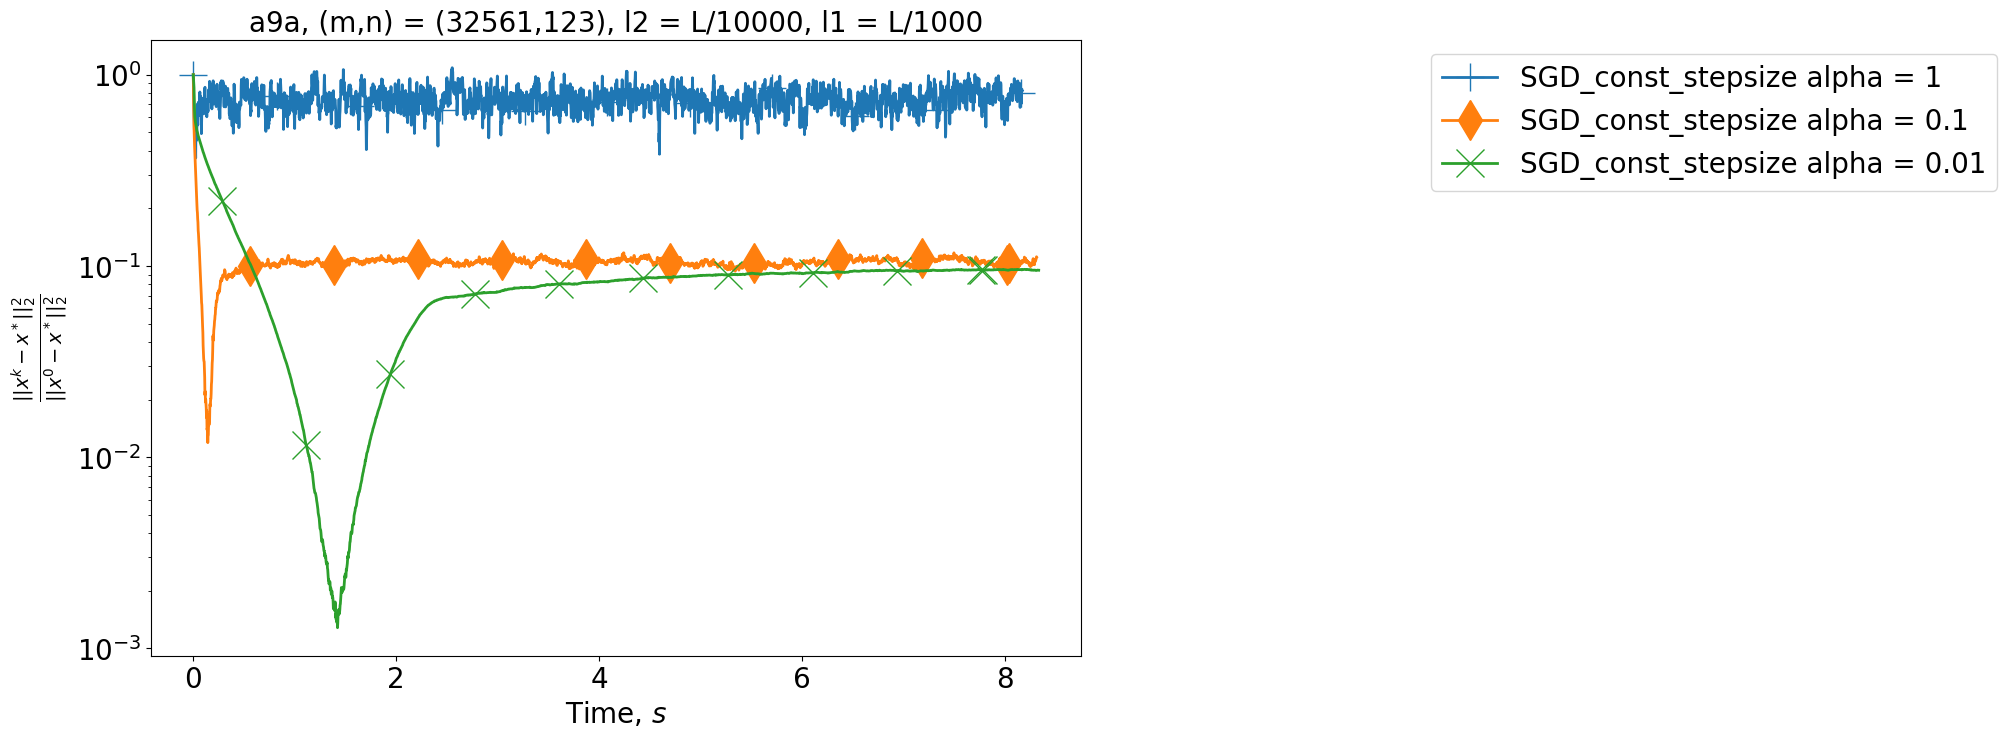

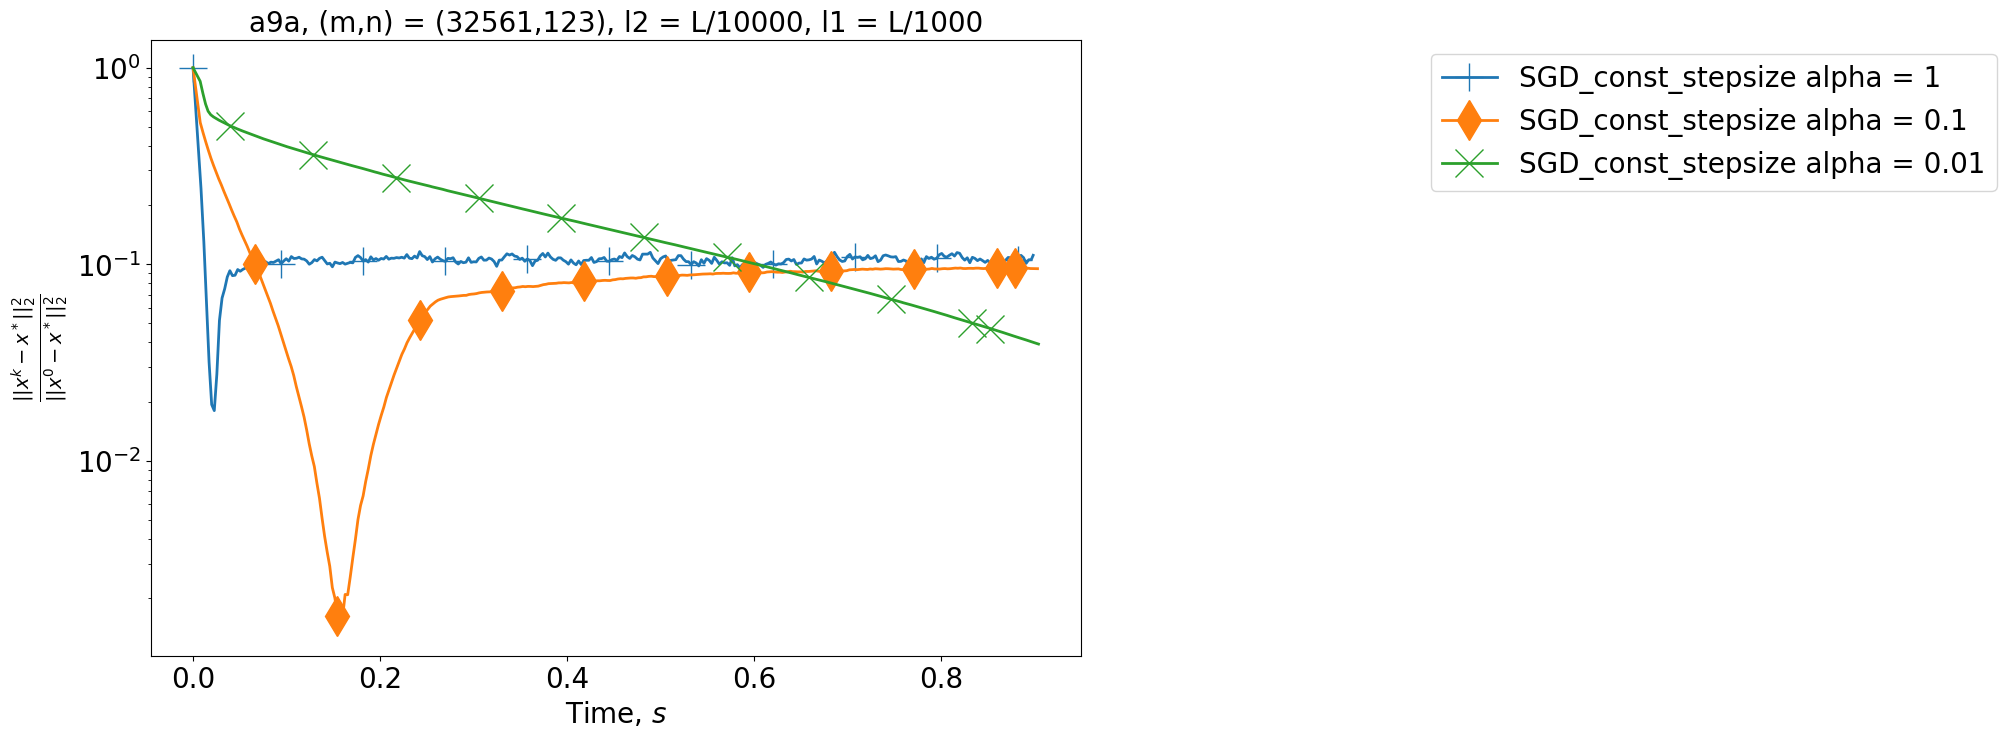

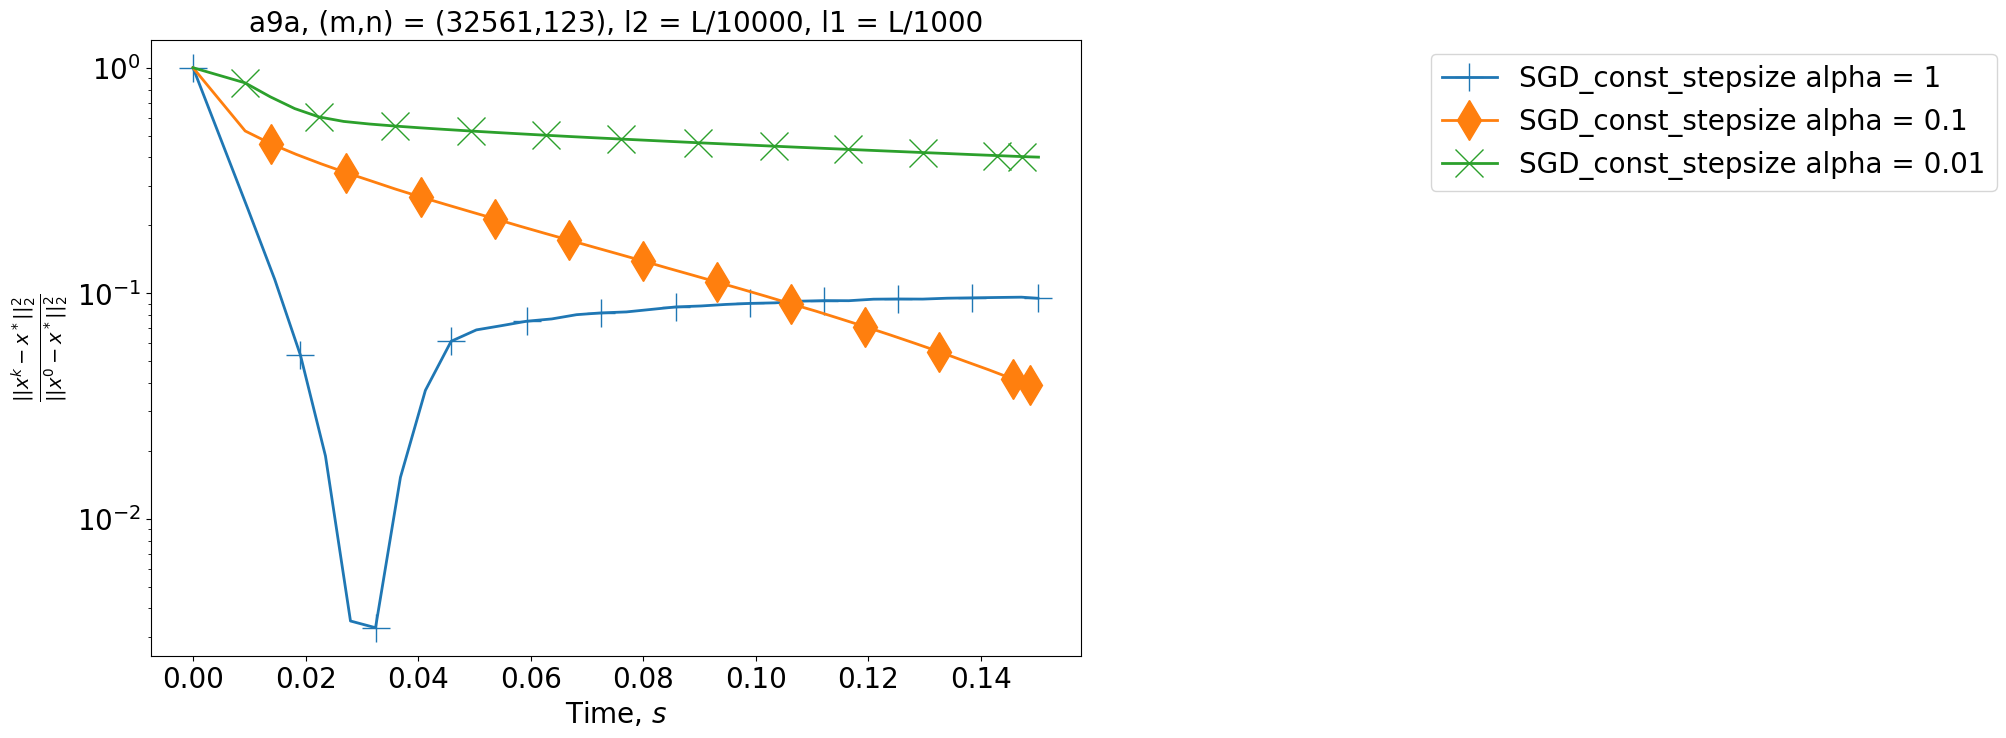

In [51]:
# Константный шаг 
dataset = 'a9a'
filename = dataset + "_x_init_all_ones"
l2 =  L / 10000
l1 = L / 1000
S = 10
figsize = (12, 8)
fontsize = 20
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = np.ones(n)
save_info_period = 100
mode_y = 'squared_distances'
mode_x = ['time']
for batch_size in batches:
    M = int(2 * m / batch_size)
    methods = []
    for alpha in alphas:
        gamma = alpha / (L + l2)
        res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             l1=l1, S=S, max_t=np.inf, batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        methods.append(['SGD_const_stepsize', [gamma, l2, l1, S, batch_size], f' alpha = {alpha}', None])
    for mode in mode_x:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
        args_for_plots = [dataset, filename, mode_y, mode, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

    На графиках выше размер батча уменьшается сверху вниз.
    
    Чем меньше значение alpha, тем точнее результат, но тем медленнее будет сходится метод. 
    Ответ зависит от желаемой точности 
    Можно заметить, что чем больше размер батча, тем быстрее сходится метод. 

### Уменьшающийся шаг

In [53]:
batches = [1, 10, 100]
Ts = [1, 2]
bettas = [0.5, 0.9]

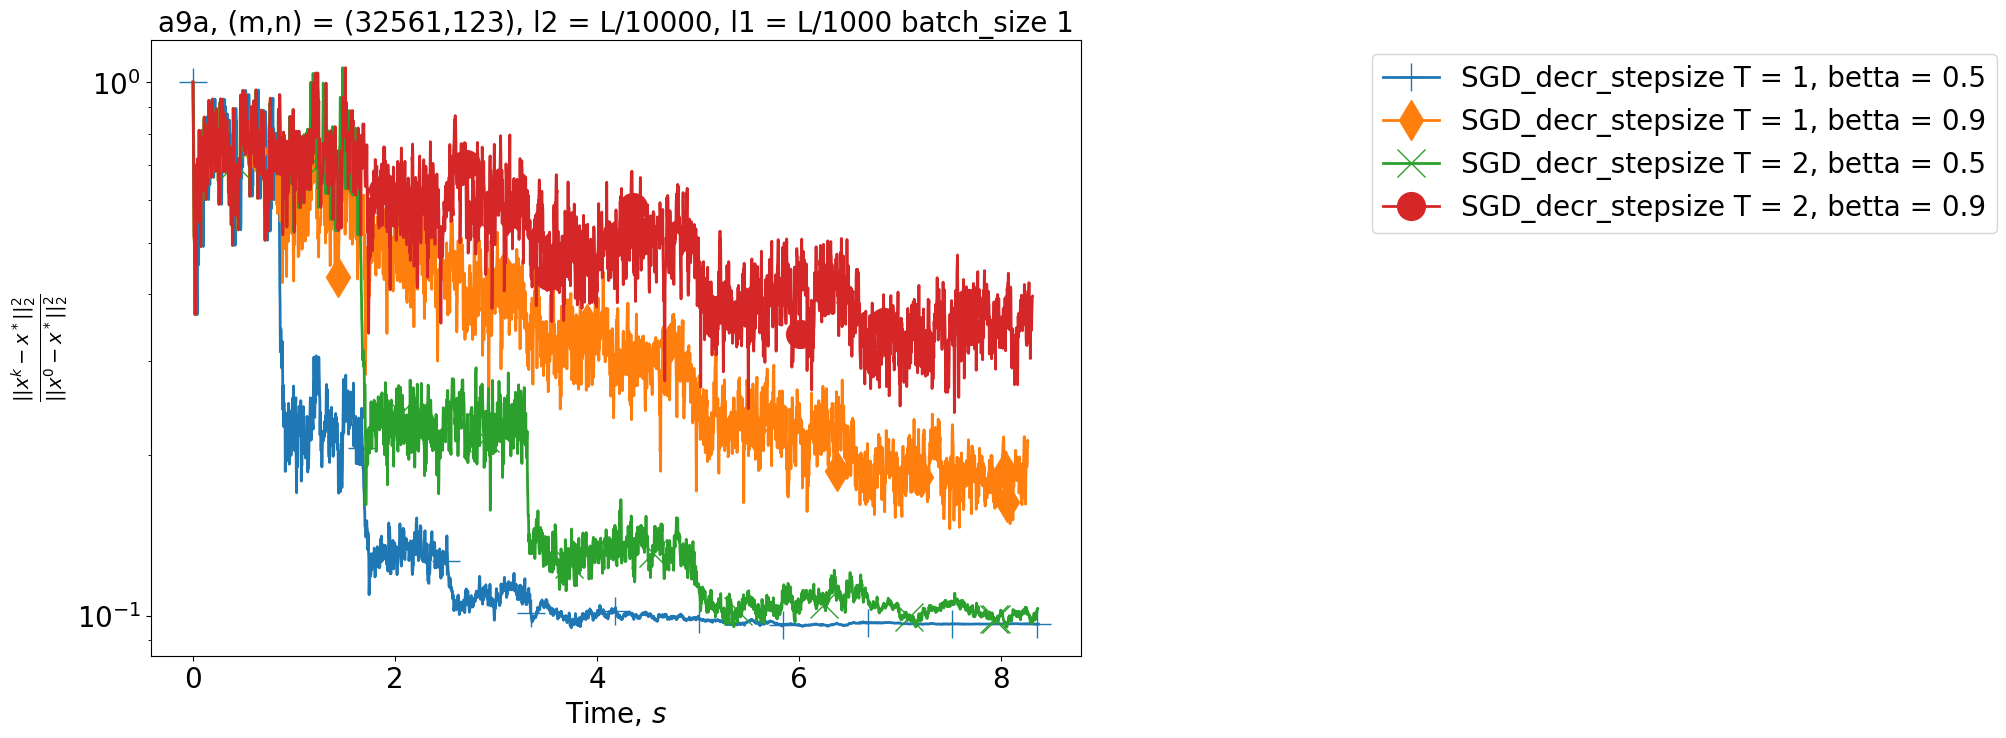

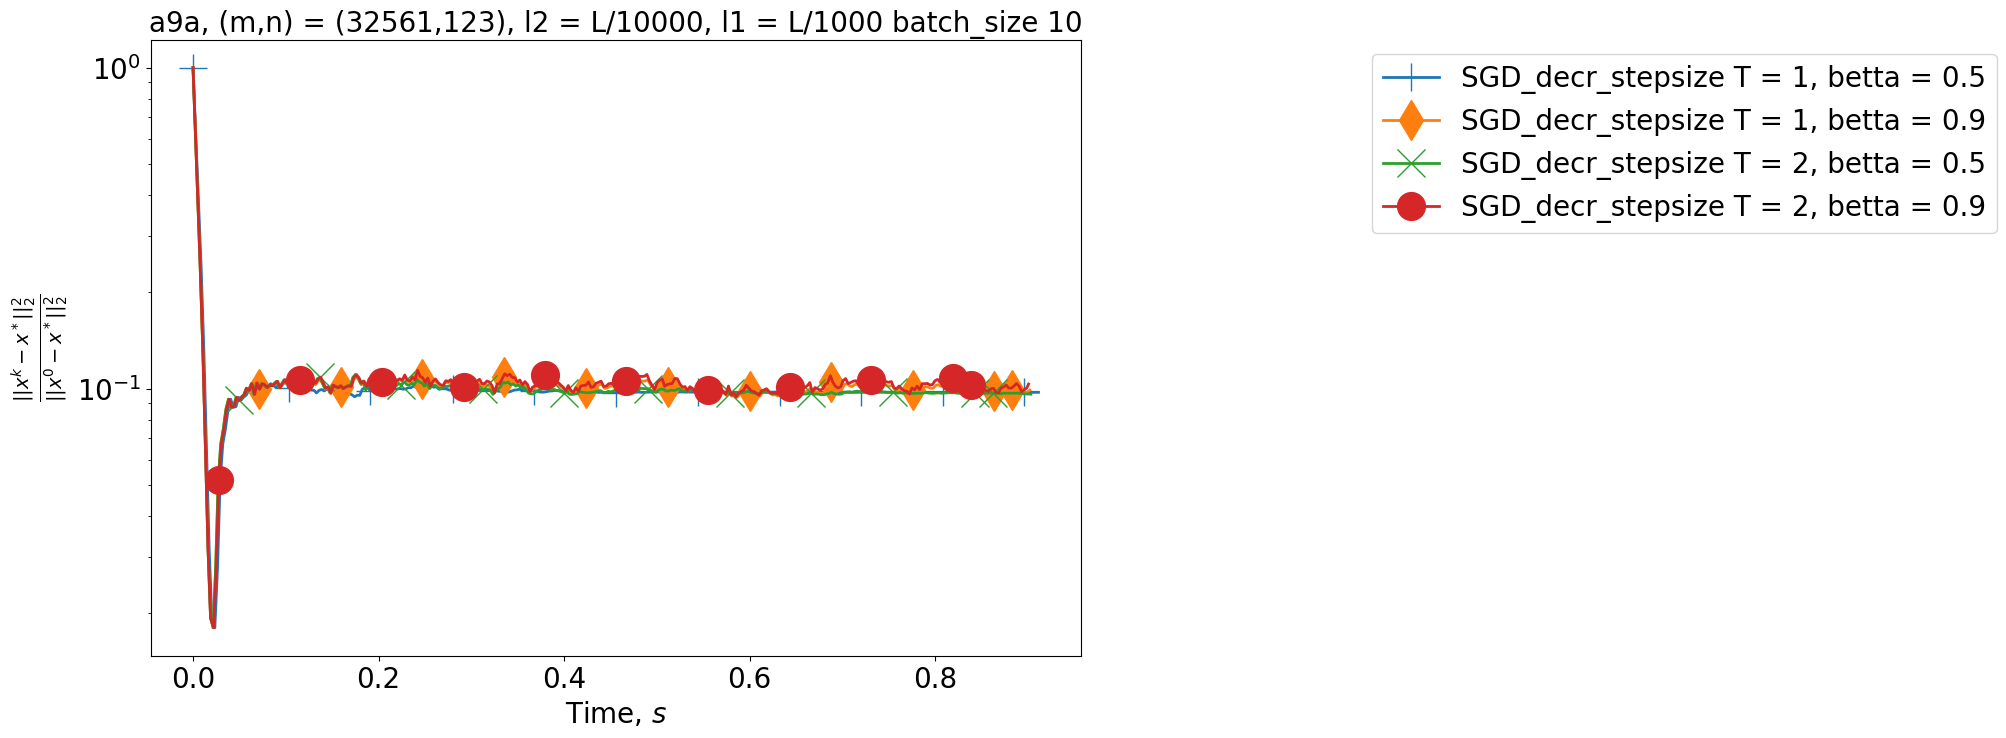

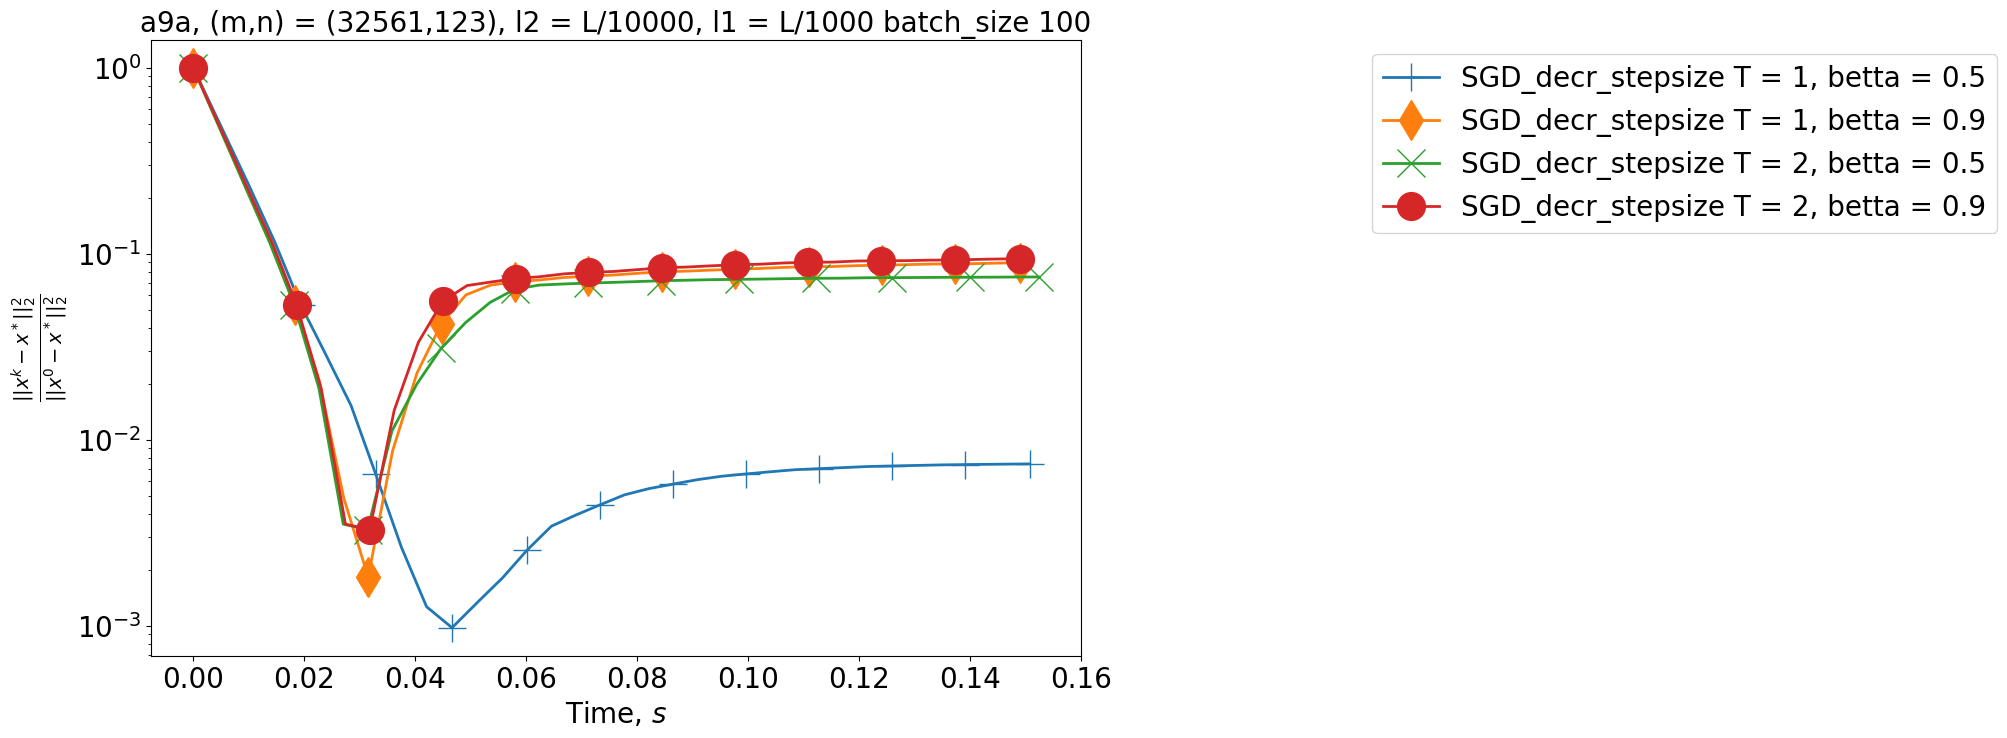

In [59]:
# Константный шаг 
dataset = 'a9a'
filename = dataset + "_x_init_all_ones"
l2 =  L / 10000
l1 = L / 1000
S = 10
gamma = 1 / (L + l2)
gamma_schedule = [gamma, 1, 0.5]
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = np.ones(n)
save_info_period = 100
mode_y = 'squared_distances'
mode_x = ['time']
for batch_size in batches:
    M = int(2 * m / batch_size)
    methods = []
    for t in Ts:
        for betta in bettas:
            gamma_schedule = [gamma, t, betta]
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
                 sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                 l1=l1, S=S, max_t=np.inf,
                 batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                 x_star=x_star, f_star=f_star)
            methods.append(['SGD_decr_stepsize', [gamma_schedule, l2, l1, S, batch_size], f' T = {t}, betta = {betta}', None])
    for mode in mode_x:
        title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))+' batch_size '+ str(batch_size)
        args_for_plots = [dataset, filename, mode_y, mode, figsize, fontsize, title, methods]
        make_plots(args=args_for_plots)
        plt.show()

    При увеличении размера батча точность метода увеличивается. При малых T и betta, например (1, 0.5) метод становится точнее вне зависимости от размера батча.
    Ответ зависит от желаемой точности
    Также ответ зависит от размера батча 

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [7]:
dataset = 'a9a'
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [8]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.73 s, sys: 3.48 ms, total: 1.74 s
Wall time: 1.73 s


Запустите функцию, тестирующую корректность работы

In [9]:
prox_gd_test(res)

Тесты пройдены!


0

In [10]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этот параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [11]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.6 s, sys: 35 µs, total: 1.6 s
Wall time: 1.6 s


Запустите функцию, тестирующую корректность работы

In [12]:
fista_test(res)

Тесты пройдены!


0

In [13]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [14]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s


Запустите функцию, тестирующую корректность работы

In [15]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

### Fista

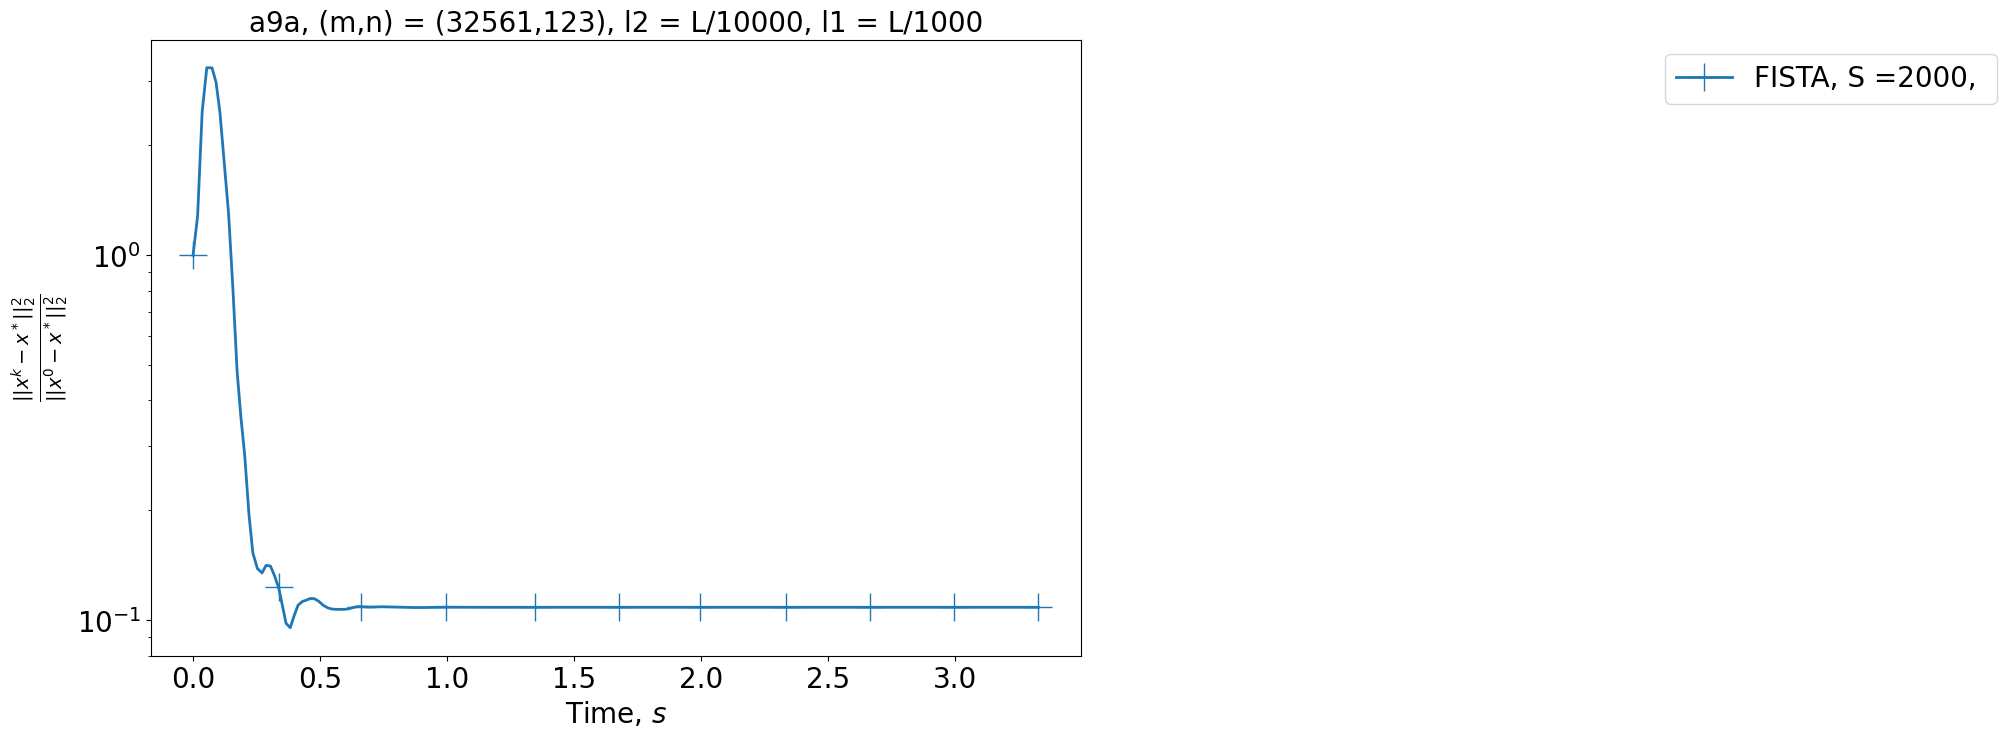

In [19]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
S = 2000
x_init = np.ones(n)
save_info_period = 10
sparse = True
figsize = (12, 8)
fontsize = 20
mode_y = 'squared_distances'
mode_x = 'time'
methods = [['FISTA', [l2, l1, S], f', S ={S}, ', None]]
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

### Prox-GD

In [26]:
args_for_plots[3]

'time'

## Задание 6. Сравнение методов

## Задание 7. Эксперименты с другим датасетом